# Final projection exploration notebook

Dataset: https://www.kaggle.com/datasets/crawford/cat-dataset/data, Oct 9 2024, 11:05am

"super small projects"

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from C4_helper import *

data_dir = './cats/'
cut_img_file = 'grabCut_np_imgs.npy'

# Object detection
Goal for object detection with bboxes
Simplyfying assumption: No other animals than cats, 1 animal at a time


In [2]:
data = DataLoader(data_dir)

if os.path.isfile(cut_img_file):
    img_ROIs = np.load(cut_img_file)
else:
    img_ROIs = get_ROIs(data.train['imgs'])  # currently skips images with no bbox (131/7997)

    if cut_img_file:
        np.save(cut_img_file, img_ROIs)

print('Amount of image-ROIs to work with:', len(img_ROIs))

Amount of image-ROIs to work with: 7866


## Example: From image to ROI
### 1. Original image

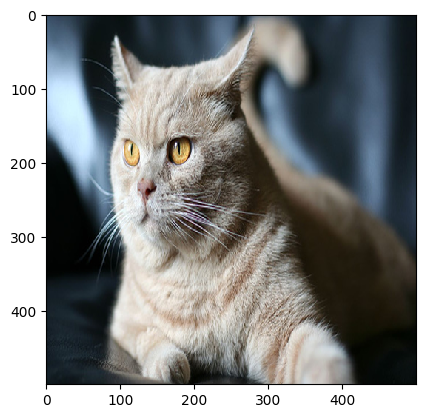

In [3]:
ex_file = data.train['imgs'][4]
plt.imshow(Image.open(ex_file).resize((500,500)), interpolation='nearest')

[[56, 20, 439, 495]]

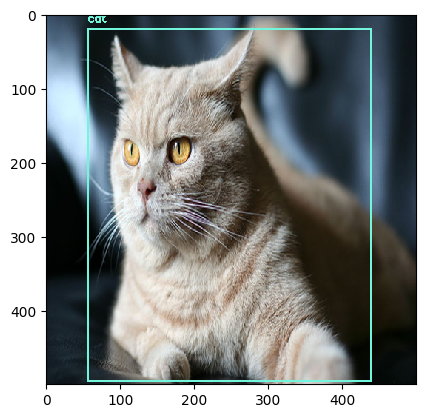

In [4]:
bbox_img, bbox = get_bbox(ex_file)
plt.imshow(bbox_img, interpolation='nearest')

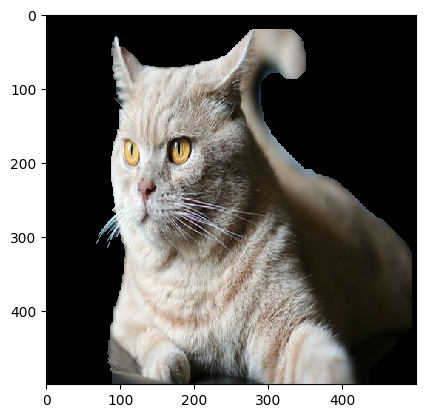

In [10]:
plt.imshow(grabcut_algorithm(ex_file, bbox), interpolation='nearest')

refine to: face, body, paws, tail?

In [6]:
# lit:
# https://pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/, big overview
# Faster R-CNN paper: https://arxiv.org/abs/1506.01497
# faster r-cnn in pytorch: http://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn


# Unsupervised clustering

In [7]:
# ?? use ggplot in r 
# on clustering https://www.geeksforgeeks.org/clustering-in-machine-learning/

# project https://www.trpkovski.com/2023/10/23/grouping-images-by-colours-exploring-colour-based-image-clustering

In [8]:
# features: max pooling for darkest & lightest areas, also mean colour
# normalise with cnn first to reduce noise, also adjust for lighting
# later adapt if u use different region?

In [9]:
# code example?
# https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb
